## Contact density distribution for bipolar cell types
This notebook calculates the contact density distribution for all bipolar cell types and generates figures 3H&I

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
import seaborn as sns
from scipy.spatial import ConvexHull
from scipy.spatial import distance_matrix
%matplotlib inline
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
matplotlib.rcParams.update({'mathtext.default': 'regular'})
matplotlib.rcParams.update({'font.size': 14})
sns.set_style("whitegrid")

In [3]:
skeleton_data=loadmat('data/skeletons_OPL_final.mat')
skeleton_ids=skeleton_data['kn_allSkeletons_e2006_IDs'].flatten()
skeletons=skeleton_data['kn_allSkeletons_e2006'].flatten()
M=np.loadtxt('data/coordinate_rotation')

In [5]:
soma_data=loadmat('data/soma_positions.mat')
soma_pos=soma_data['kn_e2006_ALLSKELETONS_FINAL2012_allSomata'].astype(float)
soma_internal_ids=soma_data['kn_e2006_ALLSKELETONS_FINAL2012_cellIDs']
soma_line_ids=soma_data['kn_e2006_ALLSKELETONS_FINAL2012_cellIDs_pure_forSomata']
soma_pos[:,:3]=np.dot(M,soma_pos[:,:3].T).T
soma_pos[:,:3]*=[16.5,16.5,25]

In [6]:
cone_means=np.loadtxt('data/cone_means_rot.txt')
cone_means[:,1:]*=[16.5,16.5,25]

In [7]:
cell_ids=np.loadtxt('data/BC_IDs_new')

In [8]:
contact_summary=pd.read_pickle('data/cone_contact_predictions')
true_contacts=contact_summary[(contact_summary['prediction']==1)&\
                              ((contact_summary['cone_type']=='blue')|(contact_summary['cone_type']=='green'))]\
                                .reset_index().drop('index',axis=1)

In [9]:
for i in range(true_contacts.shape[0]):
    true_contacts.loc[i,'BC_excentricity']=np.linalg.norm(\
        soma_pos[soma_line_ids[0,np.where(soma_internal_ids==cell_ids[cell_ids[:,0]==true_contacts.ix[i,'cell'],1])[1][0]]-1,1:3]\
        -cone_means[cone_means[:,0]==true_contacts.ix[i,'cone'],2:])/1000

In [10]:
BC_data=np.hstack((cell_ids[:,[0,4]],np.zeros((cell_ids.shape[0],1))))
for i in range(BC_data.shape[0]):
    nodes_complete=np.empty((0,3))
    for skel in np.where(skeleton_ids==BC_data[i,0])[0]:
        nodes=skeletons[skel].item()[list(skeletons[skel].dtype.names).index('nodes')][:,:3]
        edges=skeletons[skel].item()[list(skeletons[skel].dtype.names).index('edges')]
        nodes=nodes[np.unique(edges)-1,:]
        nodes=nodes[:,:3]/[16.5,16.5,25]
        nodes=np.dot(M,nodes.T).T
        nodes_complete=np.concatenate((nodes_complete,nodes[nodes[:,0]<soma_pos[soma_line_ids[0,np.where(soma_internal_ids==cell_ids[i,1])[1][0]]-1,0],0:3]),axis=0)
    nodes_complete=nodes_complete[:,1:]*[16.5,25]
    hull=ConvexHull(nodes_complete)
    hull_to_soma=nodes_complete[hull.vertices,:]-soma_pos[soma_line_ids[0,np.where(soma_internal_ids==cell_ids[i,1])[1][0]]-1,1:3]
    BC_data[i,2]=np.max(np.sqrt(hull_to_soma[:,0]**2+hull_to_soma[:,1]**2))/1000
BC_data=pd.DataFrame(BC_data,columns=['cell','type','rad_max'])

In [11]:
for i in range(true_contacts.shape[0]):
    true_contacts.loc[i,'BC_excentricity_norm_max']=true_contacts.ix[i,'BC_excentricity']/BC_data[BC_data['cell']==true_contacts.ix[i,'cell']]['rad_max'].item()

In [12]:
pal = sns.color_palette("Paired",12)
pal=pal+[(0.3,0.3,0.3)]

/gpfs01/bethge/home/cbehrens/.virtualenvs/default/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


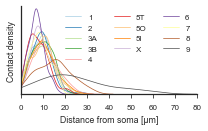

In [13]:
plt.figure(figsize=(8/2.54,4/2.54))
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 4, "ytick.major.size": 4,"lines.linewidth":0.7})
ax=sns.kdeplot(true_contacts[true_contacts['type']==58]['BC_excentricity'],label=str(58),c=pal[0])
for i in range(59,71):
    sns.kdeplot(true_contacts[true_contacts['type']==i]['BC_excentricity'],label=str(i),ax=ax,c=pal[i-58])
ax.set(xlim=(0,80),xlabel='Distance from soma [µm]',ylabel='Contact density',yticks=[])
plt.legend(ncol=3,labels=['1','2','3A','3B','4','5T','5O','5I','X','6','7','8','9'])
sns.despine()
# plt.savefig('figures/contact_distribution.svg',bbox_inches='tight',dpi=300,background='transparent')
plt.show( )

/gpfs01/bethge/home/cbehrens/.virtualenvs/default/lib/python3.4/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


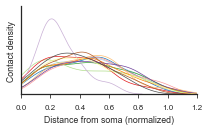

In [14]:
plt.figure(figsize=(8/2.54,4/2.54))
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 4, "ytick.major.size": 4,"lines.linewidth":0.7})
ax=sns.kdeplot(true_contacts[true_contacts['type']==58]['BC_excentricity_norm_max'],label=str(58),c=pal[0])
for i in range(59,71):
    sns.kdeplot(true_contacts[true_contacts['type']==i]['BC_excentricity_norm_max'],label=str(i),ax=ax,c=pal[i-58])
ax.set(xlim=(0,1.2),xlabel='Distance from soma (normalized)',xticks=(0,0.2,0.4,0.6,0.8,1,1.2),ylabel='Contact density',yticks=[])
# plt.legend(ncol=2,labels=['1','2','3A','3B','4','5T','5O','5I','X','6','7','8','9'],bbox_to_anchor=(1.05,1))
ax.legend_.remove()
sns.despine()
# plt.savefig('figures/paper/contact_distribution_normalized.svg',bbox_inches='tight',dpi=300,background='transparent')
plt.show()